In [1]:
import torch
from mamba_ssm import Mamba2Simple, Mamba2

batch, length, dim = 5, 2744, 192
x = torch.randn(batch, length, dim).to("cuda")
x = x.contiguous()



/root/workplace/rulstm2/RULSTM/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/root/workplace/rulstm2/RULSTM/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/root/workplace/rulstm2/RULSTM/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/root/workplace/rulstm2/RULSTM/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx

In [2]:
# d_model * expand / headdim = multiple of 8
model = Mamba2Simple(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=dim, # Model dimension d_model
    d_state=128,  # SSM state expansion factor, typically 64 or 128
    d_conv=4,    # Local convolution width
    expand=4,    # Block expansion factor
    headdim=32,
    chunk_size=196,
    use_mem_eff_path=False
).to("cuda")


In [3]:
y, d = model(x)
assert y.shape == x.shape
print(d.shape)

from MambaChunkScanCombinedFn (batch, nheads, headdim, dstate)
final_states shape: torch.Size([5, 24, 32, 128])
states shape: torch.Size([5, 14, 24, 32, 128])
torch.Size([5, 24, 32, 128])


Output shape: torch.Size([5, 2744, 192])
Output mean: -0.0064
Output std: 0.5733


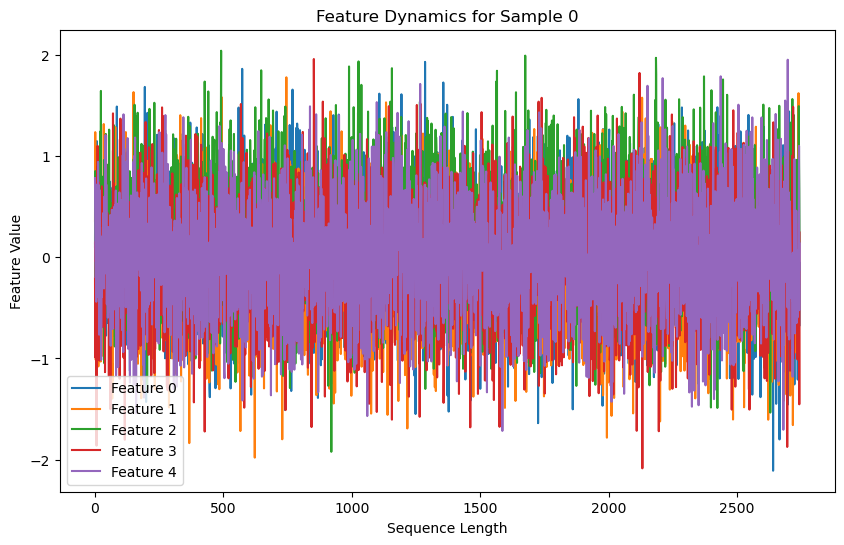

In [4]:
import matplotlib.pyplot as plt

# 打印输出张量的形状
print(f"Output shape: {y.shape}")

# 打印输出张量的均值和标准差
print(f"Output mean: {y.mean().item():.4f}")
print(f"Output std: {y.std().item():.4f}")

# 如果你想要可视化某个特定批次的输出
# 例如我们可以画出第一个样本的某些维度的值变化
sample_idx = 0
feature_idx = 0  # 选择要可视化的特征维度

plt.figure(figsize=(10, 6))
for feature_idx in range(min(dim, 5)):  # 只画出前几个维度的变化
    plt.plot(y[sample_idx, :, feature_idx].cpu().detach().numpy(), label=f"Feature {feature_idx}")

plt.title("Feature Dynamics for Sample 0")
plt.xlabel("Sequence Length")
plt.ylabel("Feature Value")
plt.legend()
plt.show()